In [1]:
#ephemeris sim
using LinearAlgebra
#make sure to cite this package
using SPICE
using Downloads: download 
using DifferentialEquations
using Plots

In [4]:
#finer integration on the reference trajectory. Kinda close for the dt of 8 hours but it diverges as time goes on./

In [5]:
#I need to get the correct times for xtraj and find the correct inverse matrix at those exact times...


#Integrate initial condition of xtraj to a certain small timestep and just compare that point in the 
#transformation to see if that works

In [6]:
# using Pkg
# Pkg.activate(".")

In [7]:
using DelimitedFiles
#xtraj_old  = readdlm("xtraj.txt", '\t', Float64, '\n')

# #in days
# time_steps = readdlm("time.txt", '\t', Float64, '\n')

# #period 
# #T_periodic_n = 3.414975413662902


# T_periodic_n = 3.414975410587678

In [8]:
xtraj_cr3bp_units = readdlm("reference_trajectory41.txt")

xtraj_si = [xtraj_cr3bp_units[1:3, :]*3.850e5; xtraj_cr3bp_units[4:6, :]*1.025] #parameters to get to si units. km and seconds

T_corrected = 3.414975413662902*375764.8206399649 #multiply by timescale in cvx mpc file. in seconds

1.2832276238049301e6

In [9]:
N_period = 41

41

In [10]:
Δt = T_corrected/(N_period-1)

32080.690595123255

In [11]:
# Load leap seconds kernel
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls")

# laptop 
# furnsh("/home/fausto/naif0012.tls")

In [12]:
# Convert the calendar date to ephemeris seconds past J2000

#was 2018
#et = utc2et("2018-02-06T20:45:00")

et = 0

0

In [13]:
# Load a planetary ephemeris kernel
furnsh("/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp")

#laptop
# furnsh("/home/fausto/de440.bsp")

In [14]:
#gravitational parameters for the bodies (km3/s2)

#moon 
μ_m = 4902.80058214776

#earth
μ_e = 398600.432896939

#sun
μ_s = 132712440017.987

1.32712440017987e11

In [15]:
#units used to normalize
#also in km and seconds

#distance
l_star = 385692.50

#time
t_star = 377084.152667038

#in km
lunar_radius = 1738.2 

1738.2

In [16]:
#get the jacobian that maps from rotating frame to inertial frame
function get_transformation(time)

    #time is already wrt et
    
    #state of the moon (position and velocity) relative to Earth (in km and km/s)
    moon_state = spkezr("moon",time,"J2000","NONE","earth")[1]

    #position of the moon relative to Earth
    r_moon = moon_state[1:3]

    #velocity of the moon relative to Earth
    v_moon = moon_state[4:6]

    #x component of the rotating frame expressed in inertial coordinates
    x̃ = r_moon/norm(r_moon)
    #z component of the rotating frame expressed in inertial coordinates
    z̃ = cross(r_moon, v_moon)/norm(cross(r_moon, v_moon))
    #x component of the rotating frame expressed in inertial coordinates
    ỹ = cross(z̃, x̃)

    #instantanous rotation matrix from rotating frame to inertial frame (centered at Earth)
    C = [x̃ ỹ z̃]

    #instantanous angular velocity
    θ_dot = norm(cross(r_moon, v_moon))/(norm(r_moon)^2)

    #θ_dot = (cross(r_moon, v_moon)/(norm(r_moon)^2))[3]

    #θ_dot = 2*pi/2.361e6


    return C, θ_dot

end

get_transformation (generic function with 1 method)

In [17]:
function cr3bp_to_ephem(x, t)

    time = et + t

    #get transformation takes in time wrt et
    C, θ_dot = get_transformation(time)

    C̄ = [θ_dot.*C[:,2] -θ_dot.*C[:,1]]

    #transformation matrix
    C̃ = [C zeros(3,3); C̄ zeros(3) C]

    #apply the rotation to get the state in the inertial frame
    x_ephem = C̃*x

    return x_ephem

end

cr3bp_to_ephem (generic function with 1 method)

In [18]:
function ephem_to_cr3bp(x, t)

    time = et + t

    #get transformation takes in time wrt et
    C, θ_dot = get_transformation(time)

    C̄ = [θ_dot.*C[:,2] -θ_dot.*C[:,1]]

    #transformation matrix
    C̃ = [C zeros(3,3); C̄ zeros(3) C]

    #get the inverse transformation matrix

    C_inv = inv(C̃)
    #C_inv = C̃'
    #apply the rotation to get the state in the rotating frame
    x_cr3bp = C_inv*x

    return x_cr3bp

end

ephem_to_cr3bp (generic function with 1 method)

In [19]:
function ephem_dynamics_scaled!(du, u, p, t)
    
    #scaled version
    du[1:6] = scaled_ephemeris_dynamics(u[1:6], t)
    
    
end

ephem_dynamics_scaled! (generic function with 1 method)

In [20]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [21]:
function just_dynamics_integrate_scaled(x_0, period)
    
    #integrate from 0 to period
    tspan = (0.0, period)
    prob = ODEProblem(ephem_dynamics_scaled!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate_scaled (generic function with 1 method)

In [22]:
#the state is in km and s as well as the time

function ephemeris_model_EarthMoon(x, t)

    xdot = zeros(6)

    xdot[1:3] = x[4:6]

    #position of the spacecraft relative to the earth 
    r_qi = x[1:3]

    time = et + t

    #get positions of moon and sun relative to earth 
    rqj_moon = spkpos("moon", time, "J2000", "none", "earth")[1]
    

    #println("position of the satellite: ", r_qi)

    #println("position of the moon: ", rqj_moon)

    rij_moon = rqj_moon- r_qi 

    #println("vector from satellite to moon: ", rij_moon)

    #println("distance to moon : ", norm(rij_moon))

    #r_qi - vector that defines the position of the satellite wrt Earth
    #rqj is the position of a planetary body wrt satellite

    #just Earth and Moon
    xdot[4:6] = (-μ_e/(norm(r_qi))^3)*r_qi + μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3));


    #display((-μ_e/(norm(r_qi))^3)*r_qi)

    #display(μ_m.*((rij_moon/norm(rij_moon)^3)-(rqj_moon/norm(rqj_moon)^3)))
                
    return xdot

end

ephemeris_model_EarthMoon (generic function with 1 method)

In [23]:
#sat_pose = [35677.75392672705, -383227.521788774, -204700.13822902984]
#2024
#moon_pose = [30336.261021197115, -325480.3753119168, -176061.98671653145]

#2018
# sat_pose = [-338899.19758259197, -265393.89399550087, -68933.27991895752]
# moon_pose = [-305665.5295916485, -238568.75389771274, -64082.58948032478]


In [24]:
# norm(sat_pose - moon_pose)

In [25]:
# (sat_pose - moon_pose)/norm(sat_pose - moon_pose)

In [26]:
# moon_pose/norm(moon_pose)

In [27]:
#these dynamics are all relative to the Earth
# scatter([sat_pose[1]], [sat_pose[2]], [sat_pose[3]], label="Satellite")
# scatter!([moon_pose[1]], [moon_pose[2]], [moon_pose[3]], label= "Moon")
# scatter!([0], [0], [0], label = "Earth")

In [28]:
l_star 

385692.5

In [29]:
#the x is scaled here as well as the t 

function scaled_ephemeris_dynamics(x,t)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)

    #get to original units (km and s)
    q_original = x[1:3]*l_star 
    v_original = x[4:6]*(l_star/t_star)
    t_original = t*t_star

    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = ephemeris_model_EarthMoon(x_original, t_original)
    
    #then scale the output
    v_scaled = ẋ_original[1:3]/(l_star/t_star)
    
    a_scaled = ẋ_original[4:6]/(l_star/(t_star)^2)

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

scaled_ephemeris_dynamics (generic function with 1 method)

In [30]:
L_cr = 3.850e5 #in km - distance between centers of m1 and m2
V_cr = 1.025 #in km/s - orbital velocity of m1
T_cr = 2.361e6 #in seconds - orbital period of m1 and m2
time_scale = T_cr/(2*pi)

375764.8206399649

In [31]:
L_nasa = 389703
T_nasa = 382981

382981

In [32]:
#mass paramter for earth moon
μ_earth_moon = 1.215058560962404E-2

0.01215058560962404

In [33]:
#position of Earth in rotating frame
pose_m1 = [-μ_earth_moon, 0, 0]

3-element Vector{Float64}:
 -0.01215058560962404
  0.0
  0.0

In [34]:
pose_m2 = [1-μ_earth_moon, 0, 0]

3-element Vector{Float64}:
 0.987849414390376
 0.0
 0.0

In [35]:
#norm(pose_m2 - x0_test[1:3])*L_cr 

In [36]:
#seems periodic, not sure if it's correct
# x0_test = [1.1201297302380415,
#  0.0,
#  0.0059396759100811495,
#  0.0,
#  0.17677819141944426,
#  0.0]

#  x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]

#  #in cr3bp units 
# T_periodic = 3.414975413662902

# x0_dim = [x0_test_earthcentered[1:3]*L_cr; x0_test_earthcentered[4:6]*(L_cr/T_cr)]

# T_dim = T_periodic*time_scale

In [37]:
#this is in km and seconds
#xtraj_test_initial = [xtraj[1:3,1]; xtraj[4:6,1]/86400]


xtraj_test_initial = [xtraj_si[1:3, 1]; xtraj_si[4:6, 1]]

6-element Vector{Float64}:
 431249.946141646
      0.0
   2286.7752253812428
      0.0
      0.18119764620493034
      0.0

In [38]:
#Initial Condtion from xtraj
x0_test = [xtraj_test_initial[1:3] + [μ_earth_moon*l_star, 0, 0]; xtraj_test_initial[4:6]]

#x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]

 #in cr3bp units 
#T_periodic = T_periodic_n

#x0_dim = [x0_test_earthcentered[1:3]*L_cr; x0_test_earthcentered[4:6]*(L_cr/T_cr)]

#T_dim = T_periodic*t_star 

T_dim = T_corrected

1.2832276238049301e6

In [39]:
################################################################################################################
#from https://ssd.jpl.nasa.gov/tools/periodic_orbits.html

#in nasa cr3bp units
#x0_test = [1.1808985497899205E+0, -2.5444988241150091E-26, 1.0295054075242347E-4, 3.3765359485568778E-15, -1.5585631393981156E-1, 5.5263881873244218E-18]
#T_periodic = 3.4155308065628454

#larger orbit
# x0_test = [1.1805068248439281E+0,	-3.3114436259161434E-27,	1.9906874796338979E-2,	3.3672394329658290E-15,	-1.5811356683023692E-1, 2.2436379855191516E-15]
# T_periodic = 3.1503862907153901
# x0_test_earthcentered = [x0_test[1:3] - pose_m1; x0_test[4:6]]


# x0_dim = [x0_test_earthcentered[1:3]*L_nasa; x0_test_earthcentered[4:6]*(L_nasa/T_nasa)]

# T_dim = T_periodic*T_nasa
#################################################################################################################

In [40]:

# y = 23
# #ECI
# xx = [xtraj[1:3,y] + [μ_earth_moon*l_star, 0, 0]; xtraj[4:6,y]/86400]
# display(xx)
# x_test_ephem = cr3bp_to_ephem(xx, 100)

In [41]:
# ephem_to_cr3bp(x_test_ephem, 100)

In [42]:
x_test_ephem = cr3bp_to_ephem(x0_test, 0)

6-element Vector{Float64}:
 -315699.84244171454
 -289709.09187984234
  -80299.25184887837
       0.8464169651825069
      -0.8184740424258685
      -0.3747772276425021

In [43]:
#this transform gives original x0_dim
#test = ephem_to_cr3bp(x_test_ephem, 0)

In [44]:
x_test_ephem_scaled = [x_test_ephem[1:3]/l_star; x_test_ephem[4:6]/(l_star/t_star)]

T_ephem_scaled = T_dim/t_star

3.403027188305123

In [45]:
#test just one step 
#sol = just_dynamics_integrate_scaled(x_test_ephem_scaled, time_steps[2]*86400/t_star)


sol = just_dynamics_integrate_scaled(x_test_ephem_scaled, Δt/t_star)

all_states_2 = get_state(sol)[:,end]

6-element Vector{Float64}:
 -0.7422079490584561
 -0.812849180921414
 -0.23791974198326793
  0.9629482359075721
 -0.6438833588960929
 -0.3298038020357553

In [46]:
all_states_2_ephem_scaled = [all_states_2[1:3]*l_star; all_states_2[4:6]*(l_star/t_star)]

6-element Vector{Float64}:
 -286264.0393922286
 -313509.8327125325
  -91763.86008488157
       0.9849311084831662
      -0.6585823897519083
      -0.33733279963370555

In [47]:
#just integrating one step is pretty good. close enough kind of...

In [48]:
Δt/3600

8.911302943089794

In [49]:
test = ephem_to_cr3bp(all_states_2_ephem_scaled, Δt)

6-element Vector{Float64}:
 434301.346475312
   5826.718057214392
   2123.9775624934264
     -0.10487905747422407
      0.17981751185640543
     -0.01034523005093807

In [50]:
test_barycenter = [test[1:3] - [μ_earth_moon*l_star, 0, 0]; test[4:6]]

6-element Vector{Float64}:
 429614.9567350721
   5826.718057214392
   2123.9775624934264
     -0.10487905747422407
      0.17981751185640543
     -0.01034523005093807

In [51]:
test_barycenter - xtraj_si[:,2]

6-element Vector{Float64}:
 -1652.0760730892653
    51.50405638943448
  -113.83347039631326
    -0.10605283797397091
     0.0019114593530475121
    -0.007311275564433428

In [52]:
xtraj_si 

6×41 Matrix{Float64}:
    4.3125e5  431267.0         …  431267.0            4.3125e5
    0.0         5775.21            -5775.21           0.0025296
 2286.78        2237.81             2237.81        2286.78
    0.0            0.00117378         -0.0011738     -1.67418e-8
    0.181198       0.177906            0.177906       0.181198
    0.0           -0.00303395  …       0.00303395    -9.83623e-10

In [53]:
all_states_ephem_41 = zeros(6, 41)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [54]:
all_states_ephem_41[:,1] = x_test_ephem_scaled

6-element Vector{Float64}:
 -0.8185273046318363
 -0.751140071118423
 -0.2081950046964314
  0.8275256172179947
 -0.8002063580912876
 -0.36641250043616225

In [55]:
for i=1:40

    one_dt_step = just_dynamics_integrate_scaled(all_states_ephem_41[:,i], Δt/t_star)

    one_dt_step_state = get_state(sol)[:,end]

    all_states_ephem_41[:,i+1] = one_dt_step_state

end

In [56]:
all_states_cr3bp = zeros(6, 41)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [57]:
time_count = 0

0

In [58]:
all_states_ephem_41_scaled = [all_states_ephem_41[1:3, :]*l_star; all_states_ephem_41[4:6,:]*(l_star/t_star)]

6×41 Matrix{Float64}:
     -3.157e5    -286264.0       …  -286264.0       -286264.0
     -2.89709e5       -3.1351e5          -3.1351e5       -3.1351e5
 -80299.3         -91763.9           -91763.9        -91763.9
      0.846417         0.984931           0.984931        0.984931
     -0.818474        -0.658582          -0.658582       -0.658582
     -0.374777        -0.337333  …       -0.337333       -0.337333

In [59]:
for i=1:41

    #need to center it at the barycenter
    all_states_cr3bp[:,i] = ephem_to_cr3bp(all_states_ephem_41_scaled[:,i], time_count) - [μ_earth_moon*l_star , 0, 0, 0, 0, 0]

    time_count += Δt
    
end

In [60]:
all_states_cr3bp

6×41 Matrix{Float64}:
    4.3125e5     429615.0        …      -4.3724e5      -4.39028e5
    4.00178e-11    5826.72          -39379.1          415.819
 2286.78           2123.98            1789.08        1789.2
   -2.77556e-17      -0.104879           0.101287       0.102488
    0.181198          0.179818           0.0176233      0.0205875
    5.55112e-17      -0.0103452  …      -0.00961155    -0.00960346

In [63]:
difference = all_states_cr3bp - xtraj_si

6×41 Matrix{Float64}:
 -5.82077e-11  -1652.08        …      -8.68507e5    -8.70278e5
  4.00178e-11     51.5041         -33603.8         415.816
  2.22826e-11   -113.833            -448.734      -497.573
 -2.77556e-17     -0.106053            0.102461      0.102488
  1.11022e-16      0.00191146         -0.160283     -0.16061
  5.55112e-17     -0.00731128  …      -0.0126455    -0.00960346

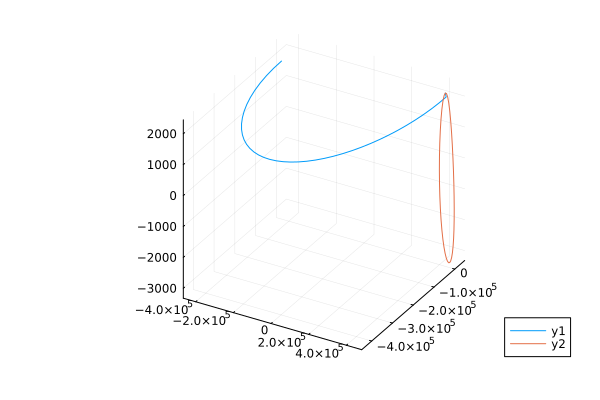

In [61]:
plot(all_states_cr3bp[1,:], all_states_cr3bp[2,:], all_states_cr3bp[3,:])

plot!(xtraj_si[1,:], xtraj_si[2,:], xtraj_si[3,:])

In [ ]:
x_test_ephem_scaled

In [ ]:
all_states_2

In [ ]:
all_states_ephem_41

In [ ]:
# sol = just_dynamics_integrate_scaled(x_test_ephem_scaled, T_ephem_scaled)

# all_states = get_state(sol)

In [ ]:
all_states[:,1]

In [ ]:
# T_ephem_scaled

In [ ]:
x_test_ephem_scaled 

In [ ]:
test = [x_test_ephem_scaled[1:3, 1]*l_star; x_test_ephem_scaled[4:6, 1]*(l_star/t_star)]

In [ ]:
ephem_to_cr3bp(test , 0)

In [ ]:
xtraj_test_initial

In [ ]:
#xtraj_i

In [ ]:
# sol.t*t_star

In [ ]:
#problem: gravity of the moon is much lower than the gravity of Earth 

In [ ]:
# using DelimitedFiles
# xtraj  = readdlm("xtraj.txt", '\t', Float64, '\n')

# #in days
# time_steps = readdlm("time.txt", '\t', Float64, '\n')
# #period 
# #T_periodic_n = 3.414975413662902


# T_periodic_n = 3.414975410587678

In [ ]:
#units of km and days

In [ ]:
# xtraj

In [ ]:
# xtraj

In [ ]:
# xtraj_transformed = [xtraj[1:3, :].+ [4677.975459705256, 0, 0]; xtraj[4:6, :]./86400]

In [ ]:
#make sure to divide by 86400 to get into seconds

In [ ]:
# time_steps[2]

In [ ]:
# time_steps

In [ ]:
#transform each of these points into the Earth Moon ephemeris model to see what it looks like

# xtraj_ephemeris = zeros(6,131)

# #x_centered = xtraj_ephemeris 

# for i=1:131

#     xtraj_ephemeris[:,i] = cr3bp_to_ephem(xtraj_transformed[:,i], time_steps[i]*86400)
# end

In [ ]:
# xtraj_ephemeris

In [ ]:
# [all_states[1:3, :].*l_star; all_states[4:6,:].*(l_star/t_star)] 

In [ ]:
#this should be all _states because xtraj_ephemeris is xtraj loaded that was 
#converted 
#xtraj_ephemeris_last = xtraj_ephemeris[:,end]

In [ ]:
# all_states

In [ ]:
# sol.t 

In [ ]:
# all_states 

In [ ]:
#transform all states into cr3bp scaled

#km/s

# all_states_cr3bp = zeros(6, size(all_states)[2])

# for i=1:size(all_states)[2]

#     ephem_scaled = [all_states[1:3,i]*l_star; all_states[4:6,i]*(l_star/t_star)]
#     all_states_cr3bp[:,i] = ephem_to_cr3bp(ephem_scaled, sol.t[i]*t_star)
    
# end

In [ ]:
# sol.t*t_star 

In [ ]:
#plot(all_states_cr3bp[1,:], all_states_cr3bp[2,:], all_states_cr3bp[3,:])

In [ ]:
# all_states_cr3bp[1:3, 1]

In [ ]:
# all_states_cr3bp[4:6, 1]

In [ ]:
# all_states_cr3bp

In [ ]:
#center around the barycenter

all_states_cr3bp_centered = all_states_cr3bp .- [μ_earth_moon*l_star , 0, 0, 0, 0, 0]

In [ ]:
xtraj./[1,1,1, 86400, 86400, 86400]

In [ ]:
all_states_cr3bp

In [ ]:
xtraj 

In [ ]:
pose_m2*l_star 

In [ ]:
plot(all_states_cr3bp_centered[1,:], all_states_cr3bp_centered[2,:], all_states_cr3bp_centered[3,:])

scatter!([all_states_cr3bp_centered[1,1]], [all_states_cr3bp_centered[2,1]], [all_states_cr3bp_centered[3,1]])

plot!(xtraj_si[1,:], xtraj_si[2,:], xtraj_si[3,:])

scatter!([xtraj_si[1,1]], [xtraj_si[2,1]], [xtraj_si[3,1]]) 

In [ ]:
plot(all_states_cr3bp_centered[1,1:2], all_states_cr3bp_centered[2,1:2], all_states_cr3bp_centered[3,1:2])

scatter!([all_states_cr3bp_centered[1,1]], [all_states_cr3bp_centered[2,1]], [all_states_cr3bp_centered[3,1]])

plot!(xtraj[1,1:50], xtraj[2,1:50], xtraj[3,1:50])

scatter!([xtraj[1,1]], [xtraj[2,1]], [xtraj[3,1]])

In [ ]:
#this is in the scaled units
all_states_cr3bp_centered[:,1:2]

In [ ]:
xtraj[:, 1:2]

In [ ]:
xtraj[4:6, 1]/86400

In [ ]:
all_states_cr3bp_centered[:,1] - [xtraj[1:3,1]; xtraj[4:6,1]/86400]

In [ ]:
#pretty off after one step
all_states_cr3bp_centered[:,2] - [xtraj[1:3,2]; xtraj[4:6,2]/86400]

In [ ]:
xtraj_ephemeris_last

In [ ]:
xtraj_ephemeris_last_scaled = [xtraj_ephemeris_last[1:3]*l_star; xtraj_ephemeris_last[4:6]*(l_star/t_star)]

In [ ]:
#the units are good here for the velocity. check units overall in the transformation

x_cr3bp = ephem_to_cr3bp(xtraj_ephemeris_last_scaled, 1.2832276238049301e6)

In [ ]:
sol.t*t_star 

In [ ]:
x_cr3bp_normalized = [x_cr3bp[1:3]/l_star; x_cr3bp[4:6]/(l_star/t_star)]

In [ ]:
all_states_cr3bp[:,end]

In [ ]:
μ_earth_moon

In [ ]:
xtraj

In [ ]:
time_steps*time_scale

In [ ]:
#center at the barycenter
x_cr3bp_normalized_centered = x_cr3bp_normalized-[μ_earth_moon, 0,0,0,0,0]


In [ ]:
# x0_test = [1.1201297302380415,
#  0.0,
#  0.0059396759100811495,
#  0.0,
#  0.17677819141944426,
#  0.0]

In [ ]:
#this is periodic in the Earth centered J2000 frame
#now need to convert the final state of the J200 frame to a state in the CR3BP

In [ ]:
#T_dim

In [ ]:
moon_orbit = zeros(6, 1283227)


for i=1:1283227

    moon_orbit[:,i] = spkezr("moon",et+i,"J2000","NONE","earth")[1]

end

In [ ]:
plot(moon_orbit[1,:], moon_orbit[2,:], moon_orbit[3,:])

scatter!([0], [0], [0])

In [ ]:
#I believe there is something wrong with the epoch...

In [ ]:
#plot(xtraj_ephemeris[1,:], xtraj_ephemeris[2,:], xtraj_ephemeris[3,:])

plot(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 
scatter!([all_states[1,1]*l_star], [all_states[2,1]*l_star], [all_states[3,1]*l_star])
scatter!([0], [0], [0])
plot!(moon_orbit[1,:], moon_orbit[2,:], moon_orbit[3,:])

#this is relative to the Earth 

In [ ]:
time_steps

In [ ]:
time_steps

In [ ]:
#μ_earth_moon*l_star 

In [ ]:
xtraj_transformed = [xtraj[1:3, :].+ [μ_earth_moon*l_star , 0, 0]; xtraj[4:6, :]./86400]

In [ ]:
#transform each of these points into the Earth Moon ephemeris model to see what it looks like

xtraj_ephemeris = zeros(6,131)

#x_centered = xtraj_ephemeris 

for i=1:131

    xtraj_ephemeris[:,i] = cr3bp_to_ephem(xtraj_transformed[:,i], time_steps[i]*86400)
end

In [ ]:
xtraj_ephemeris

In [ ]:
plot(xtraj_ephemeris[1,:], xtraj_ephemeris[2,:], xtraj_ephemeris[3,:])

plot!(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 

plot!(moon_orbit[1,:], moon_orbit[2,:], moon_orbit[3,:])

#plot!(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 

In [ ]:
time_steps[2]*86400

In [ ]:
test = ephem_to_cr3bp(xtraj_ephemeris[:,2], time_steps[2]*86400) 

test_corrected = [test[1:3] - [μ_earth_moon*l_star , 0, 0]; test[4:6]]

In [ ]:
xtraj[:,2]

In [ ]:
test2 = ephem_to_cr3bp([all_states[1:3,2]*l_star; all_states[4:6, 2]*l_star/t_star], time_steps[2]*86400)

test2_corrected = [test2[1:3] - [μ_earth_moon*l_star , 0, 0]; test2[4:6]]

In [ ]:
test_corrected 

In [ ]:
time_steps[2]*86400

In [ ]:
#simulating just 11 is off alot in the y direction

In [ ]:
xtraj_ephemeris[:,1:2]

In [ ]:
[all_states[1:3,1:2]*l_star; all_states[4:6, 1:2]*(l_star/t_star)]

In [ ]:
xtraj_ephemeris

In [ ]:
[all_states[1:3, :]*l_star; all_states[4:6, :]*(l_star/t_star)][:,end]

In [ ]:
#convert both back to x_cr3bp

In [ ]:
xtraj_ephemeris

In [ ]:
all_states_scaled = [all_states[1:3, :]*l_star; all_states[4:6, :]*(l_star/t_star)]

In [ ]:
sol.t*t_star

In [ ]:
time_steps*86400

In [ ]:
#11 seconds vs 6409 seconds? 

In [ ]:
all_states_cr3bp = zeros(6, 316)


for i=1:316
    all_states_cr3bp[:,i] = ephem_to_cr3bp(all_states_scaled[:,i], sol.t[i]*t_star)
end

In [ ]:
xtraj_cr3bp = zeros(6,131)

#x_centered = xtraj_ephemeris 

for i=1:131

    xtraj_cr3bp[:,i] = ephem_to_cr3bp(xtraj_ephemeris[:,i], time_steps[i]*86400)
end

In [ ]:
μ_earth_moon*l_star 

In [ ]:
xtraj_cr3bp

In [ ]:
xtraj_transformed

In [ ]:
all_states_cr3bp

In [ ]:
all_states_cr3bp[:,1] - xtraj_cr3bp[:,1]

In [ ]:
all_states_cr3bp

In [ ]:
xtraj_cr3bp

In [ ]:
#plot(xtraj_transformed[1,:], xtraj_transformed[2,:], xtraj_transformed[3,:])

plot(xtraj_cr3bp[1,1:40], xtraj_cr3bp[2,1:40], xtraj_cr3bp[3,1:40])

plot!(all_states_cr3bp[1,1:2], all_states_cr3bp[2,1:2], all_states_cr3bp[3,1:2])

scatter!([all_states_cr3bp[1,1]], [all_states_cr3bp[2,1]], [all_states_cr3bp[3,1]])

scatter!([xtraj_cr3bp[1,1]], [xtraj_cr3bp[2,1]], [xtraj_cr3bp[3,1]])

In [ ]:
# #transform all states into cr3bp scaled

# all_states_cr3bp = zeros(6, size(all_states)[2])


# for i=1:size(all_states)[2]

#     ephem_scaled = [all_states[1:3,i]*l_star; all_states[4:6,i]*(l_star/t_star)]
#     all_states_cr3bp[:,i] = ephem_to_cr3bp(ephem_scaled, sol.t[i]*t_star)
    
# end

In [ ]:
#tested on a leo orbit and dynamics work fine

#something wrong with the ephemeris to cr3bp conversion? 

In [ ]:
#rk4 to integrate the ephemeris equation

In [ ]:
function RK4_integrator(x, t)

    Δt = 1
    f1 = ephemeris_model_EarthMoon(x, t)
    f2 = ephemeris_model_EarthMoon(x+0.5*Δt*f1, t + Δt/2)
    f3 = ephemeris_model_EarthMoon(x+0.5*Δt*f2, t + Δt/2)
    f4 = ephemeris_model_EarthMoon(x+ Δt*f3, t+Δt)

    xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

    return xnext

end

In [ ]:
all_states_rk4 = zeros(6, 1000000)

all_states_rk4[:,1] = x_test_ephem

for i=1:1000000-1
    all_states_rk4[:,i+1] = RK4_integrator(all_states_rk4[:,i], i)

end

In [ ]:
all_states_rk4

In [ ]:
plot(all_states_rk4[1,:], all_states_rk4[2,:], all_states_rk4[3,:])

plot!(all_states[1,:]*l_star, all_states[2,:]*l_star, all_states[3,:]*l_star) 

In [ ]:
all_states_rk4

In [ ]:
x_test_ephem

In [ ]:
#potential error is with the transformation matrix. the part 
#corresponding to the velocities. Make sure to write out the
#derivation

In [ ]:
#the timing from simulating the ephemeris forward is off. Make sure the coincide!!!!!!

#you can define the timestep in Differential Equations.jl. Make it match the dt of the 41 knot point
#trajectory 